<a href="https://colab.research.google.com/github/kreitika/Graph-Neural-Network-for-Bike-Usage-Prediction/blob/main/Graph_Neural_Network_for_Bike_Usage_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1 — Installing PyTorch Geometric (official wheels for Colab)
# These commands are recommended by the PyG team for CUDA 12.x on Colab.

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!pip install torch_geometric -q

print("PyTorch + PyG installed.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00
PyTorch + PyG installed.


In [2]:
# Cell 2 — Generating a small synthetic dataset for GNN training

import pandas as pd
import numpy as np

np.random.seed(42)

num_stations = 15
num_hours = 500

# Random station coordinates (pretending this is Amsterdam-like)
lats = np.random.uniform(52.33, 52.42, num_stations)
lons = np.random.uniform(4.84, 4.96, num_stations)

# Create time steps
hours = np.arange(num_hours)

rows = []

for h in hours:
    hour_of_day = h % 24
    is_weekend = 1 if (h // 24) % 7 in [5,6] else 0

    # Simple synthetic weather pattern
    temp = np.random.normal(15, 5)      # degrees C
    rain = np.random.binomial(1, 0.2)   # rainy or not

    for i in range(num_stations):
        # Demand pattern: morning + evening peaks
        base = 15 + 10*np.sin((hour_of_day/24)*2*np.pi)
        weekend_adj = -3*is_weekend
        temp_adj = (temp - 15) * 0.3
        rain_adj = -5 * rain

        # final noisy demand
        demand = max(0, base + weekend_adj + temp_adj + rain_adj + np.random.normal(0,2))

        rows.append([h, i, lats[i], lons[i], hour_of_day, is_weekend, temp, rain, demand])

df = pd.DataFrame(rows, columns=[
    "hour", "station_id", "lat", "lon",
    "hour_of_day", "is_weekend", "temp", "rain", "demand"
])

df.head()


,hour,station_id,lat,lon,hour_of_day,is_weekend,temp,rain,demand
0,0,0,52.363709,4.862009,0,0,9.245032,0,14.024906
1,0,1,52.415564,4.876509,0,0,9.245032,0,12.073002
2,0,2,52.395879,4.902971,0,0,9.245032,0,15.168389
3,0,3,52.383879,4.891833,0,0,9.245032,0,13.855578
4,0,4,52.344042,4.874947,0,0,9.245032,0,12.002390


In [3]:
# Cell 3 — Building the graph (k-NN based on station coordinates)

from sklearn.neighbors import NearestNeighbors
import torch

# Extract station positions
coords = df[["station_id", "lat", "lon"]].drop_duplicates().sort_values("station_id")
pos = coords[["lat", "lon"]].values

# Find 3 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=4).fit(pos)
distances, indices = nbrs.kneighbors(pos)

# Build edge list (PyG expects [2, num_edges])
edge_index = []

for i in range(num_stations):
    for j in indices[i][1:]:   # skip itself
        edge_index.append([i, j])
        edge_index.append([j, i])   # undirected graph

edge_index = torch.tensor(edge_index).t().contiguous()

print("Edge index shape:", edge_index.shape)


Edge index shape: torch.Size([2, 90])


In [4]:
# Cell 4 — Preparing PyTorch Geometric data objects

import torch
from torch_geometric.data import Data

# We need X[t] to predict y[t+1]
df["target"] = df.groupby("station_id")["demand"].shift(-1)
df = df.dropna()

# Building feature matrix for each hour
X_list = []
Y_list = []

for t in df["hour"].unique():
    batch = df[df["hour"] == t].sort_values("station_id")

    # Features for each node
    x = batch[["hour_of_day", "is_weekend", "temp", "rain", "demand"]].values
    y = batch["target"].values

    X_list.append(torch.tensor(x, dtype=torch.float))
    Y_list.append(torch.tensor(y, dtype=torch.float))

print("Total time steps:", len(X_list))


Total time steps: 499


In [5]:
# Cell 5 — Defining a simple GCN model

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class BikeGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.gcn1 = GCNConv(in_dim, hid_dim)
        self.gcn2 = GCNConv(hid_dim, out_dim)

    def forward(self, x, edge_index):
        # First layer → GCN + ReLU
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Second layer → output
        x = self.gcn2(x, edge_index)
        return x

model = BikeGCN(5, 32, 1)
print(model)


BikeGCN(
  (gcn1): GCNConv(5, 32)
  (gcn2): GCNConv(32, 1)
)


In [6]:
# Cell 6 — Training loop

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
edge_index = edge_index.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 20

for ep in range(epochs):
    total_loss = 0

    for Xt, Yt in zip(X_list, Y_list):
        Xt = Xt.to(device)
        Yt = Yt.to(device).unsqueeze(1)  # shape [N,1]

        pred = model(Xt, edge_index)

        loss = loss_fn(pred, Yt)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {ep+1} | Loss = {total_loss:.4f}")


Epoch 1 | Loss = 28363.0376
Epoch 2 | Loss = 9519.7049
Epoch 3 | Loss = 8545.8275
Epoch 4 | Loss = 7898.7791
Epoch 5 | Loss = 7468.3503
Epoch 6 | Loss = 7194.9464
Epoch 7 | Loss = 7046.3708
Epoch 8 | Loss = 6959.6694
Epoch 9 | Loss = 6905.9447
Epoch 10 | Loss = 6872.8149
Epoch 11 | Loss = 6847.5232
Epoch 12 | Loss = 6826.0124
Epoch 13 | Loss = 6809.8276
Epoch 14 | Loss = 6796.5447
Epoch 15 | Loss = 6782.5556
Epoch 16 | Loss = 6768.9701
Epoch 17 | Loss = 6758.8540
Epoch 18 | Loss = 6746.3971
Epoch 19 | Loss = 6735.3846
Epoch 20 | Loss = 6724.9954


In [7]:
# Cell 7 — Predict bike demand for the last hour in the dataset

X_last = X_list[-1].to(device)
pred_last = model(X_last, edge_index).detach().cpu().numpy()

df_pred = df[df["hour"] == df["hour"].max()].sort_values("station_id")
df_pred["predicted_demand"] = pred_last

df_pred[["station_id", "demand", "predicted_demand"]].head(10)


,station_id,demand,predicted_demand
7470,0,3.882406,2.711326
7471,1,0.000000,0.892400
7472,2,0.348110,1.618670
7473,3,0.000000,1.595608
7474,4,3.460340,2.789691
7475,5,1.575666,1.557493
7476,6,1.901439,2.665504
7477,7,0.000000,0.884368
7478,8,3.289716,1.511693
7479,9,2.002579,1.644406


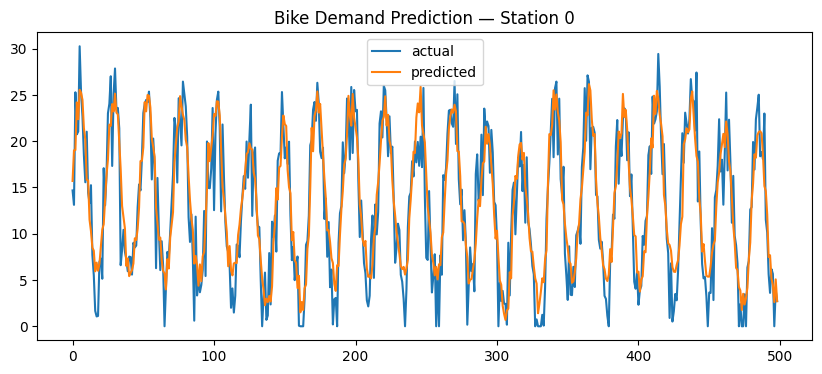

In [8]:
# Cell 8 — Plot actual vs predicted for station 0

import matplotlib.pyplot as plt

station = 0

actual = [y[station].item() for y in Y_list]
predicted = []

for Xt in X_list:
    pred = model(Xt.to(device), edge_index).detach().cpu()[station].item()
    predicted.append(pred)

plt.figure(figsize=(10,4))
plt.plot(actual, label="actual")
plt.plot(predicted, label="predicted")
plt.title("Bike Demand Prediction — Station 0")
plt.legend()
plt.show()
